# Time Series Forcasting with Feature Engineering

## Objective

Time series forecasting is a critical task in a variety of domains, ranging from finance to power
management. While traditional statistical methods have been used, recent developments in
machine learning and feature engineering have led to a significant improvement in forecasts.

This project aims to build an end-to-end time series forecasting pipeline,
illustrating how careful feature engineering can greatly improve the predictive capability over a
range of modeling approaches.

## Dataset

The dataset that we have chosen to use in this project is the [Historical Weather Data](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities) dataset from Kaggle.
This dataset contains daily temperature data for major cities around the world, including the date and the average temperature for each day.

# Installing and Importing Required Libraries

In [1]:
from numpy.distutils.fcompiler import dummy_fortran_file
!pip install -r requirements.txt

/var/folders/6l/_kjv1kfd461bglbcp2k8jyqh0000gn/T/ipykernel_36106/964807111.py:1: DeprecationWarning: 

  `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
  of the deprecation of `distutils` itself. It will be removed for
  Python >= 3.12. For older Python versions it will remain present.
  It is recommended to use `setuptools < 60.0` for those Python versions.
  For more details, see:
    https://numpy.org/devdocs/reference/distutils_status_migration.html 


  from numpy.distutils.fcompiler import dummy_fortran_file


# Loading the dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/city_temperature.csv", low_memory=False)

# Data Exploration

In [3]:
# View the first rows to get an idea of the data
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


## Understanding the data charecteristics

This is "getting to know the data" and involves analyzing the types of features, their ranges, as well as the distribution of their values.

In [4]:
# Feature types
print("Feature types:")
df.dtypes

Feature types:


Region             object
Country            object
State              object
City               object
Month               int64
Day                 int64
Year                int64
AvgTemperature    float64
dtype: object

In [5]:
# Range of features
print("Range of features:")
df.describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}"))

Range of features:


,Month,Day,Year,AvgTemperature
count,2906327.00,2906327.00,2906327.00,2906327.00
mean,6.47,15.72,2006.62,56.00
std,3.46,8.80,23.38,32.12
min,1.00,0.00,200.00,-99.00
25%,3.00,8.00,2001.00,45.80
50%,6.00,16.00,2007.00,62.50
75%,9.00,23.00,2013.00,75.50
max,12.00,31.00,2020.00,110.00


From the range of features, we observe the following key points:

- The minimum value in the `Year` column is 200.
- The minimum value in the `AvgTemperature` column is -99.

We will check the values near these minimums to get an idea of what they may represent.

In [6]:
# Check the 5 lowest unique values in the Year and AvgTemperature columns
unique_years = df["Year"].unique()
unique_years.sort()
unique_temps = df["AvgTemperature"].unique()
unique_temps.sort()

print("Lowest Year and AvgTemperature values:")
pd.DataFrame({
    "Year": unique_years[:5],
    "AvgTemperature": unique_temps[:5]
})

Lowest Year and AvgTemperature values:


,Year,AvgTemperature
0,200,-99.0
1,201,-50.0
2,1995,-49.1
3,1996,-47.7
4,1997,-46.9


The `Year` column has two values abnormal values: 200 and 201. These are likely data entry errors.
The `AvgTemperature` column has a value of -99, which is likely a placeholder for missing data since it is far from the other lowest values.

# Data Processing

This involves handling the following:

- Missing value imputation
- Outlier detection and treatment
- Resampling to different time frequencies (hourly, daily, weekly)
- Normalization/standardization of features

### Missing value imputation

In [7]:
missing_temp_values = df.isnull().sum()
print("Missing values in each column:")
missing_temp_values

Missing values in each column:


Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

The results of the missing value check show that there are no missing values in the dataset, except for the `State` column. This column is not important for the scope of this project, nor is it easy to impute values for this column without referencing a large, separate dataset that maps cities to the state/province they are in.

However, in this dataset there are actually missing `AvgTemperature` values. They are denoted by a value of `-99` in the row that doesn't have a temperature reading.

In [8]:
missing_temp_values = df[df["AvgTemperature"] == -99]
missing_year_values = df[df["Year"] < 1900]
print(f"Missing values in AvgTemperature column: {len(missing_temp_values)}")
print(f"Missing values in Year column: {len(missing_year_values)}")

Missing values in AvgTemperature column: 79672
Missing values in Year column: 440


These missing values will need to be imputed. We can determine if the missing data is correlated more to any specific location or time period:

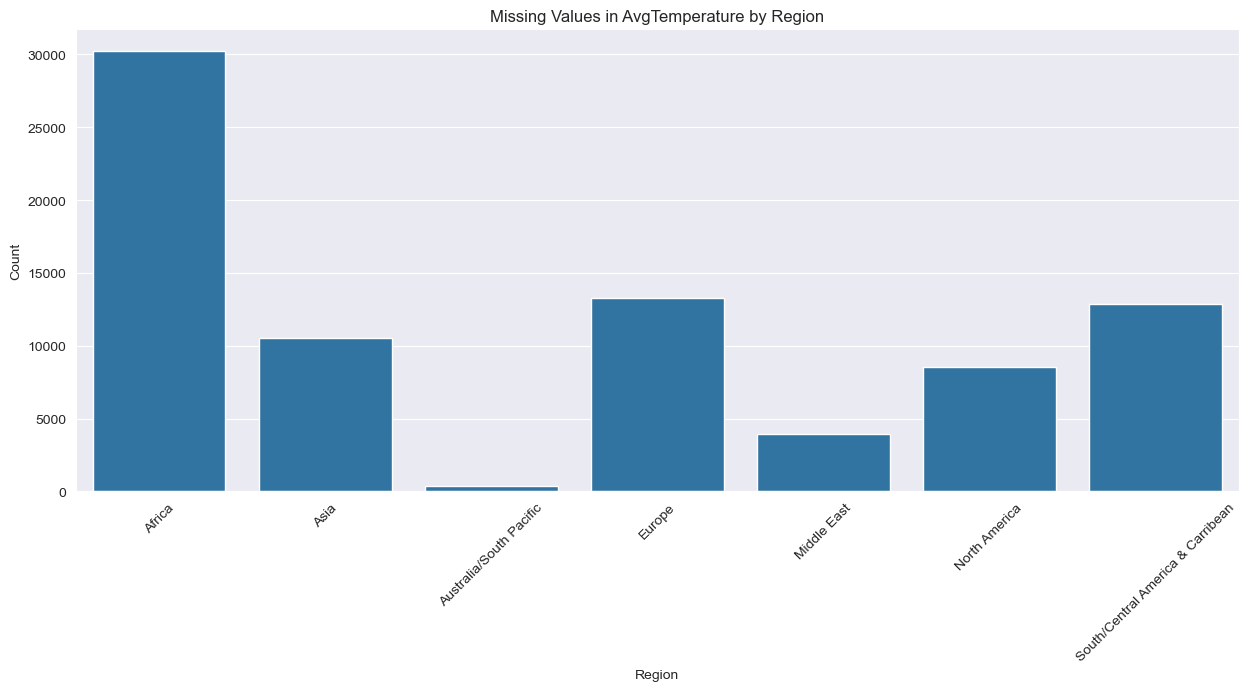

In [9]:
# Plot of the missing values in each region, along with the total number of values in each region
plt.figure(figsize=(15, 6))
sns.countplot(x="Region", data=missing_temp_values)
plt.title("Missing Values in AvgTemperature by Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

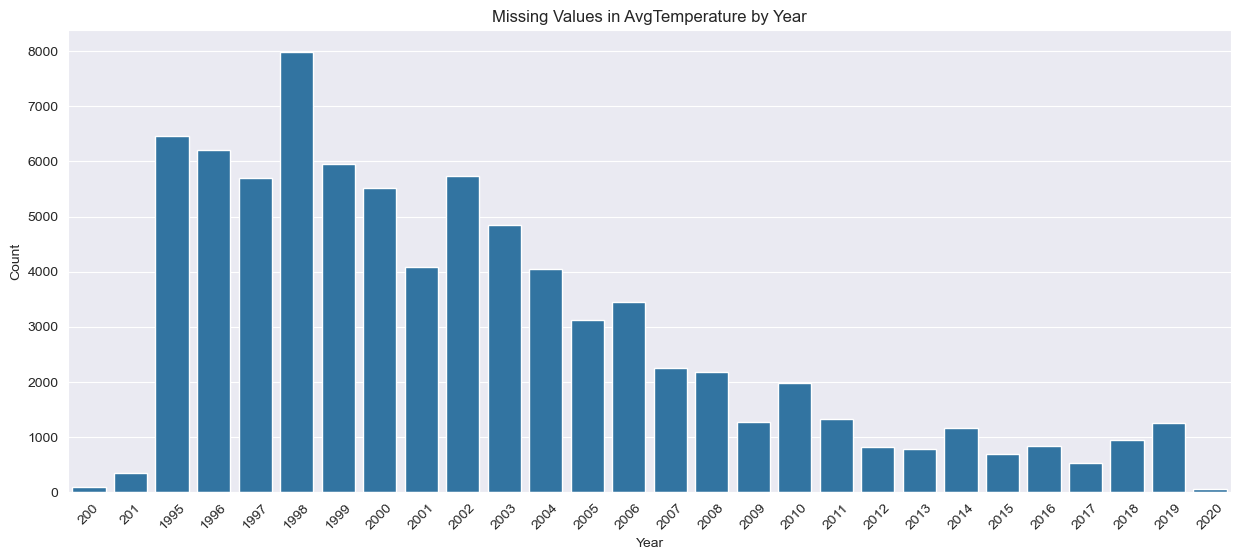

In [10]:
# Plot of the missing values by year
plt.figure(figsize=(15, 6))
sns.countplot(x="Year", data=missing_temp_values)
plt.title("Missing Values in AvgTemperature by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Missing values as a proportion of all values
missing_values_proportion = len(missing_temp_values) / len(df)
print(f"Proportion of missing values in AvgTemperature: {missing_values_proportion:.2%}")

Proportion of missing values in AvgTemperature: 2.74%


In [12]:
# By region
print("Percentage of missing values by region:")
missing_values_by_region = missing_temp_values.groupby("Region").size()
missing_values_by_region_proportion = missing_values_by_region / df.groupby("Region").size()
missing_values_by_region_proportion = missing_values_by_region_proportion.sort_values(ascending=False)
missing_values_by_region_proportion = missing_values_by_region_proportion.apply(lambda x: f"{x:.2%}")
missing_values_by_region_proportion.name = "Percentage of Missing Values"
missing_values_by_region_proportion

Percentage of missing values by region:


Region
Africa                               12.03%
South/Central America & Carribean     5.85%
Europe                                3.48%
Asia                                  3.32%
Middle East                           3.16%
Australia/South Pacific               0.70%
North America                         0.55%
Name: Percentage of Missing Values, dtype: object

In [13]:
# By year
print("Proportion of missing values by year:")
missing_values_by_year = missing_temp_values.groupby("Year").size()
missing_values_by_year_proportion = missing_values_by_year / df.groupby("Year").size()
missing_values_by_year_proportion = missing_values_by_year_proportion.sort_values(ascending=False)
missing_values_by_year_proportion = missing_values_by_year_proportion.apply(lambda x: f"{x:.2%}")
missing_values_by_year_proportion.name = "Proportion of Missing Values"
missing_values_by_year_proportion

Proportion of missing values by year:


Year
200     100.00%
201     100.00%
1998      6.70%
1995      5.45%
1996      5.23%
1999      4.98%
2002      4.81%
1997      4.81%
2000      4.61%
2003      4.08%
2001      3.42%
2004      3.41%
2006      2.93%
2005      2.65%
2007      1.95%
2008      1.90%
2010      1.72%
2019      1.18%
2011      1.17%
2009      1.11%
2014      1.06%
2018      0.89%
2016      0.78%
2012      0.74%
2013      0.71%
2015      0.64%
2017      0.49%
2020      0.18%
Name: Proportion of Missing Values, dtype: object

The main source of missing values is the Africa region, which has approximately 12% of its values missing.
Additionally, we can observe that as time passed, the number of missing values decreased.
This is likely due to improvements in data collection methods over time, as well as the proliferation of technology across the globe.

To fill in the missing values, we will apply time series forcasting.
For the missing year values, we will simply delete them since they are missing 100% of the data anyway. Additionally, `State` information is only available for the United States, so we will drop this column as well, as it is not relevant to the analysis.

In [14]:
# Delete the invalid years
df = df[df["Year"] >= 1900]

# Drop the State column
df.drop(columns=["State"], inplace=True)

### Datetime conversion

Now that the invalid years have been removed from the data, we can a separate `Date` column to simplify date handling.
In the original dataset, the date is split into three separate columns, one for month, day, and year each. For simplicity during the imputation, as well as extracting more date-related features during feature engineering, we will combine these three columns into a single datetime column.

In [15]:
df['Month'] = df['Month'].clip(lower=1, upper=12)
df['Day'] = df['Day'].clip(lower=1, upper=31)

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,Algiers,1,5,1995,47.9,1995-01-05


### Data imputation

In [16]:
from tqdm.notebook import tqdm


def simple_time_series_imputation(df, target_column='AvgTemperature', missing_value_indicator=-99):
    """
    Fill missing values using simple time series methods
    """

    # Create a copy of the dataframe
    df_copy = df.copy()

    # Replace missing value indicator with NaN if specified
    if missing_value_indicator is not None:
        df_copy[target_column] = df_copy[target_column].replace(missing_value_indicator, np.nan)

    # Count missing values before imputation
    missing_before = df_copy[target_column].isna().sum()

    if missing_before == 0:
        print("No missing values to impute.")
        return df_copy

    print(f"Missing values before imputation: {missing_before}")

    # Ensure date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_copy["Date"]):
        df_copy["Date"] = pd.to_datetime(df_copy["Date"])

    print(f"Processing each city separately")
    locations = df_copy["City"].unique()

    # Process each location
    imputed_dfs = []
    for location in tqdm(locations, desc=f"Processing Cities"):
        # Get data for this location
        location_data = df_copy[df_copy["City"] == location].copy()

        # Skip if no missing values
        if not location_data[target_column].isna().any():
            imputed_dfs.append(location_data)
            continue

        # Sort by date
        location_data = location_data.sort_values(by="Date")

        # Apply simple imputation methods
        # 1. Linear interpolation (for small gaps)
        location_data[target_column] = location_data[target_column].interpolate(method='linear')

        # 2. Forward fill then backward fill (for any remaining gaps)
        location_data[target_column] = location_data[target_column].ffill().bfill()

        imputed_dfs.append(location_data)

        # Combine all locations
        df_imputed = pd.concat(imputed_dfs)

    # Count missing values after imputation
    missing_after = df_imputed[target_column].isna().sum()
    print(f"Missing values after imputation: {missing_after}")
    print(f"Values filled: {missing_before - missing_after}")

    # If missing_value_indicator was provided, replace NaN back to the indicator for any remaining missing values
    if missing_value_indicator is not None and missing_after > 0:
        df_imputed[target_column] = df_imputed[target_column].fillna(missing_value_indicator)

    return df_imputed

In [17]:
# Apply the seasonal mean imputation function to the dataframe
df = simple_time_series_imputation(df, target_column='AvgTemperature', missing_value_indicator=-99)

Missing values before imputation: 79232
Processing each city separately


Processing Cities:   0%|          | 0/321 [00:00<?, ?it/s]

Missing values after imputation: 0
Values filled: 79232


In [18]:
missing_values = df[df["AvgTemperature"] == -99]

# Check if there are any missing values left
if len(missing_values) == 0:
    print("No missing values left in AvgTemperature column.")
else:
    print(f"Missing values left in AvgTemperature column: {len(missing_values)}")

No missing values left in AvgTemperature column.


### Unit conversion

In the dataset, the temperature is in Fahrenheit, but we will convert it to Celsius for better interpretability. This is because Canada uses the metric system and Celsius is the standard unit of temperature in Canada.

In [19]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5.0/9.0

# Convert the temperature to Celsius
df["AvgTemperature"] = fahrenheit_to_celsius(df["AvgTemperature"])

df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,Algiers,1,1,1995,17.888889,1995-01-01
1,Africa,Algeria,Algiers,1,2,1995,9.666667,1995-01-02
2,Africa,Algeria,Algiers,1,3,1995,9.333333,1995-01-03
3,Africa,Algeria,Algiers,1,4,1995,8.000000,1995-01-04
4,Africa,Algeria,Algiers,1,5,1995,8.833333,1995-01-05


### Outlier detection and treatment

/var/folders/6l/_kjv1kfd461bglbcp2k8jyqh0000gn/T/ipykernel_36106/1686574793.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/uzair/.pyenv/versions/miniconda3-latest/envs/ProjectA/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


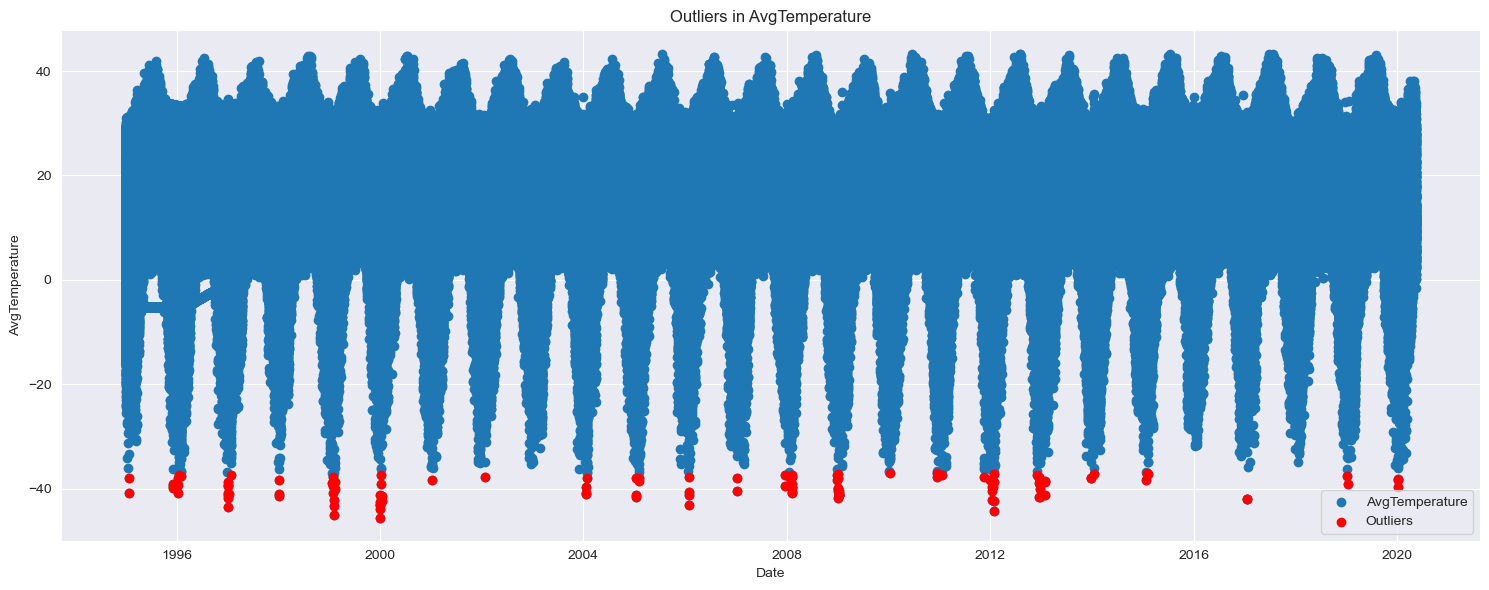

In [20]:
def detect_outliers_zscore(df, threshold=3):
    """
    Detect outliers using Z-score method
    """
    df_copy = df.copy()["AvgTemperature"]
    mean = df_copy.mean()
    std_dev = df_copy.std()
    z_scores = (df_copy - mean) / std_dev
    return np.abs(z_scores) > threshold

# Detect outliers
outliers = detect_outliers_zscore(df, threshold=5)

# Plot the outliers
plt.figure(figsize=(15, 6))
plt.scatter(df["Date"], df["AvgTemperature"], label="AvgTemperature")
plt.scatter(df["Date"][outliers], df["AvgTemperature"][outliers], color='red', label="Outliers")
plt.title("Outliers in AvgTemperature")
plt.xlabel("Date")
plt.ylabel("AvgTemperature")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Remove outliers
df = df[~outliers]

### Normalization/standardization of features

In order to improve the performance of the model, we will normalize the temperature to the range [-1, 1]. Additionally, we will convert the string columns to categorical variables.

In [22]:
# Normalize the temperature
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
df["AvgTemperature"] = scaler.fit_transform(df[["AvgTemperature"]])

# Convert string columns to categorical variables
label_encoder = LabelEncoder()
df["Region"] = label_encoder.fit_transform(df["Region"])
df["Country"] = label_encoder.fit_transform(df["Country"])
df["City"] = label_encoder.fit_transform(df["City"])

df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
0,0,1,7,1,1,1995,0.366966,1995-01-01
1,0,1,7,1,2,1995,0.162405,1995-01-02
2,0,1,7,1,3,1995,0.154112,1995-01-03
3,0,1,7,1,4,1995,0.120940,1995-01-04
4,0,1,7,1,5,1995,0.141672,1995-01-05


# Feature Engineering

For feature engineering, we will create the following features:

- Temporal features:
  - Year
  - Month
  - Day
  - Day of the week
  - Week of the year
  - Cyclic features for month and day (sine and cosine)
  - Holidays
- Statistical features:
  - Moving averages for 7, 30, and 90 days
  - Rolling standard deviation, min, and max for 7, 30, and 90 days
  - Exponentially weighted moving averages for 7, 30, and 90 days
  - Difference features for day-over-day and week-over-week changes
- Domain specific features:
  - Seasonal features (summer, winter, spring, fall)

In [23]:
# Set Date as the index for time series analysis
df_ts = df.set_index('Date').sort_index()

df_ts.describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}"))

,Region,Country,City,Month,Day,Year,AvgTemperature
count,2905767.00,2905767.00,2905767.00,2905767.00,2905767.00,2905767.00,2905767.00
mean,3.84,86.26,160.60,6.47,15.72,2006.90,0.32
std,1.84,37.95,92.89,3.46,8.80,7.28,0.26
min,0.00,0.00,0.00,1.00,1.00,1995.00,-1.00
25%,3.00,55.00,80.00,3.00,8.00,2001.00,0.14
50%,5.00,114.00,161.00,6.00,16.00,2007.00,0.36
75%,5.00,114.00,242.00,9.00,23.00,2013.00,0.53
max,6.00,124.00,320.00,12.00,31.00,2020.00,1.00


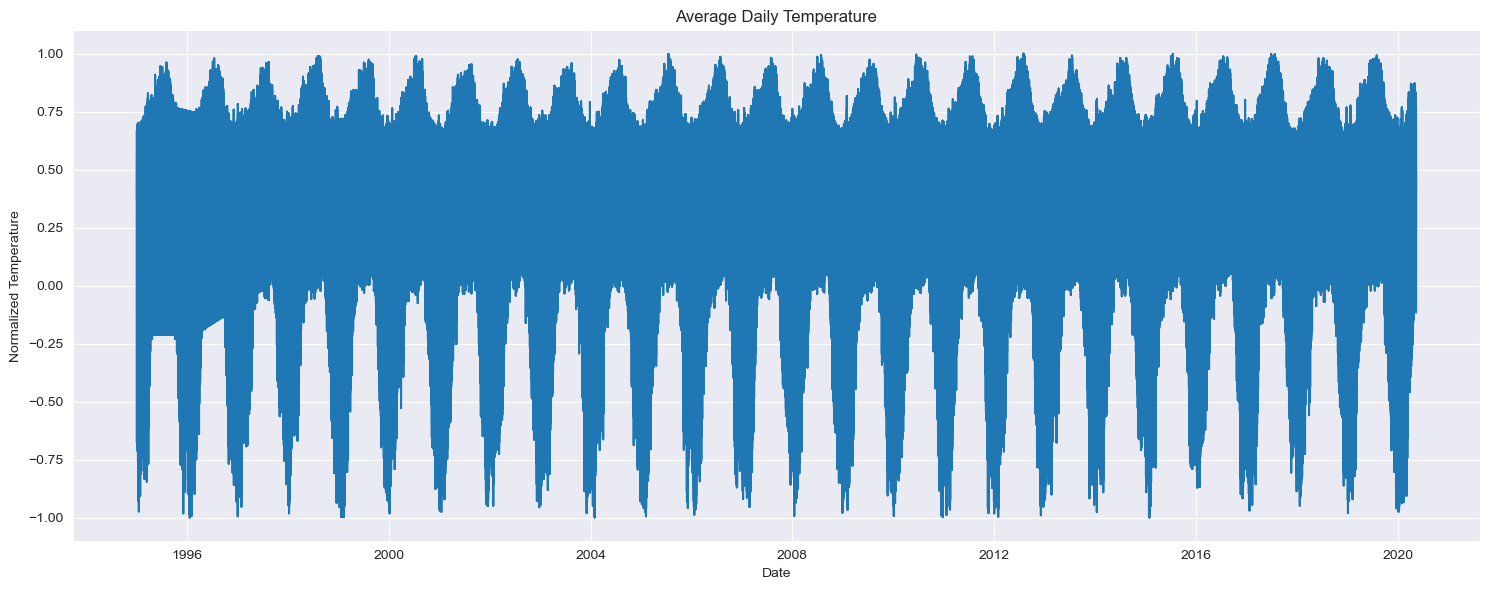

In [24]:
# Plot the temperature time series
plt.figure(figsize=(15, 6))
plt.plot(df_ts.index, df_ts['AvgTemperature'])
plt.title('Average Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Normalized Temperature')
plt.tight_layout()
plt.show()


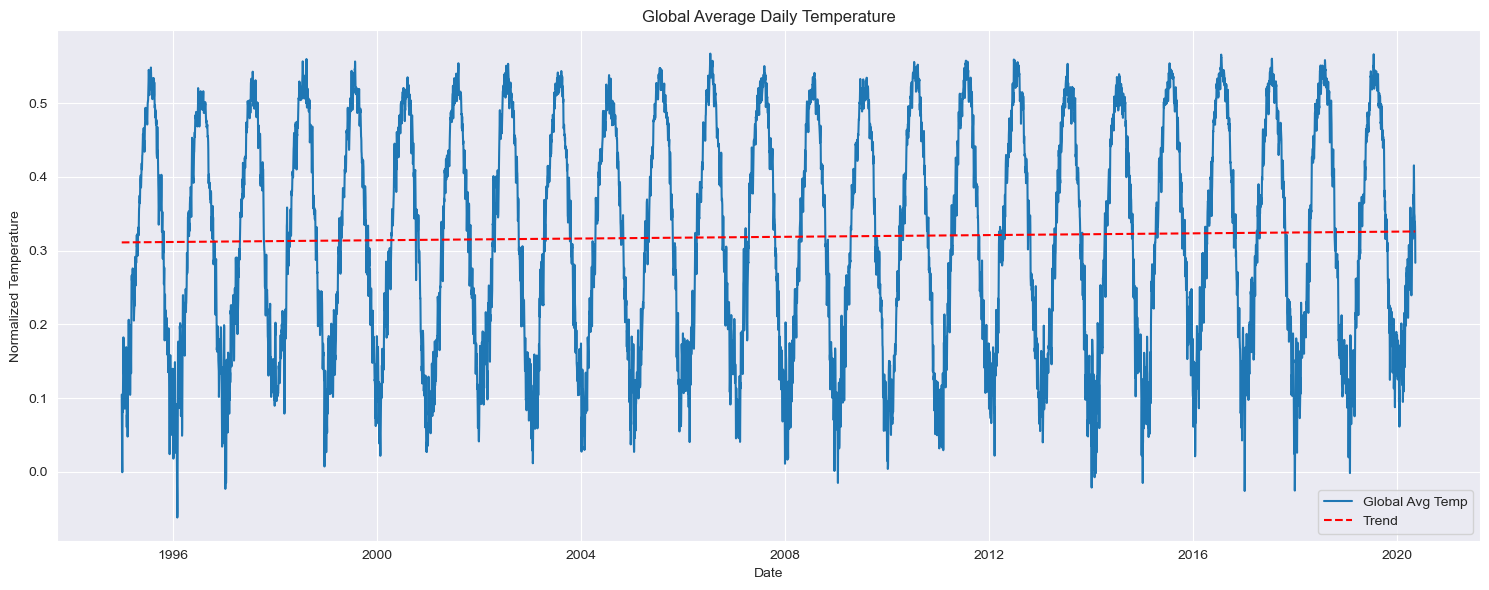

In [25]:
# Plot the global average temperature
global_avg_temp = df_ts.groupby(df_ts.index.date)['AvgTemperature'].mean()
plt.figure(figsize=(15, 6))
plt.plot(global_avg_temp.index, global_avg_temp)

# Add trend line
z = np.polyfit(range(len(global_avg_temp)), global_avg_temp, 1)
p = np.poly1d(z)
plt.plot(global_avg_temp.index, p(range(len(global_avg_temp))), color='red', linestyle='--')
plt.title('Global Average Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Normalized Temperature')
plt.legend(['Global Avg Temp', 'Trend'])
plt.tight_layout()
plt.show()

One thing we can note from this plot is that the global average temperature has been increasing over time. This shows that climate change is a real phenomenon and that the global average temperature is increasing over time.

In [26]:
def create_temporal_features(df):
    df_features = df.copy()

    # Extract date features
    df_features['DayOfWeek'] = df_features.index.dayofweek
    df_features['DayOfYear'] = df_features.index.dayofyear
    df_features['WeekOfYear'] = df_features.index.isocalendar().week

    # Cyclic encoding of features
    df_features['MonthSine'] = np.sin(2 * np.pi * df_features['Month'] / 12)
    df_features['MonthCosine'] = np.cos(2 * np.pi * df_features['Month'] / 12)
    df_features['DayOfWeekSine'] = np.sin(2 * np.pi * df_features['DayOfWeek'] / 7)
    df_features['DayOfWeekCosine'] = np.cos(2 * np.pi * df_features['DayOfWeek'] / 7)
    df_features['DayOfYearSine'] = np.sin(2 * np.pi * df_features['DayOfYear'] / 365)
    df_features['DayOfYearCosine'] = np.cos(2 * np.pi * df_features['DayOfYear'] / 365)

    return df_features

# Create temporal features
df_features = create_temporal_features(df_ts)

df_features.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,DayOfWeek,DayOfYear,WeekOfYear,MonthSine,MonthCosine,DayOfWeekSine,DayOfWeekCosine,DayOfYearSine,DayOfYearCosine
Date,,,,,,,,,,,,,,,,
1995-01-01,0,1,7,1,1,1995,0.366966,6,1,52,0.5,0.866025,-0.781831,0.62349,0.017213,0.999852
1995-01-01,6,121,66,1,1,1995,0.578438,6,1,52,0.5,0.866025,-0.781831,0.62349,0.017213,0.999852
1995-01-01,6,101,221,1,1,1995,0.546648,6,1,52,0.5,0.866025,-0.781831,0.62349,0.017213,0.999852
1995-01-01,1,105,284,1,1,1995,0.324119,6,1,52,0.5,0.866025,-0.781831,0.62349,0.017213,0.999852
1995-01-01,4,81,201,1,1,1995,0.624050,6,1,52,0.5,0.866025,-0.781831,0.62349,0.017213,0.999852


In [27]:
def create_statistical_features(df, window_sizes=[7, 30, 90]):
    df_features = df.copy()

    # Moving averages
    for window in window_sizes:
        df_features[f'MA_{window}'] = df_features['AvgTemperature'].rolling(window=window).mean()

    # Rolling statistics
    for window in window_sizes:
        df_features[f'STD_{window}'] = df_features['AvgTemperature'].rolling(window=window).std()
        df_features[f'MIN_{window}'] = df_features['AvgTemperature'].rolling(window=window).min()
        df_features[f'MAX_{window}'] = df_features['AvgTemperature'].rolling(window=window).max()

    # Exponentially weighted moving averages
    for window in window_sizes:
        df_features[f'EWMA_{window}'] = df_features['AvgTemperature'].ewm(span=window).mean()

    # Difference features
    df_features['DiffDay'] = df_features['AvgTemperature'].diff()
    df_features['DiffWeek'] = df_features['AvgTemperature'].diff(7)
    df_features['DiffMonth'] = df_features['AvgTemperature'].diff(30)

    # Percentage change features
    df_features['PctChangeDay'] = df_features['AvgTemperature'].pct_change()
    df_features['PctChangeWeek'] = df_features['AvgTemperature'].pct_change(7)
    df_features['PctChangeMonth'] = df_features['AvgTemperature'].pct_change(30)

    # Lag features
    for window in window_sizes:
        df_features[f'Lag_{window}'] = df_features['AvgTemperature'].shift(window)

    return df_features

# Create statistical features
df_features = create_statistical_features(df_features)

missing_values = df_features.isnull().sum().sum()
if missing_values > 0:
    print("There are still missing values in the features.")
    df_features = df_features.bfill().ffill()
    print(f"Missing values filled: {missing_values}")
else:
    print("No missing values in the features.")

There are still missing values in the features.
Missing values filled: 699


Now that we have created the features, we can visualize them to get an idea of their distributions and relationships with the target variable.

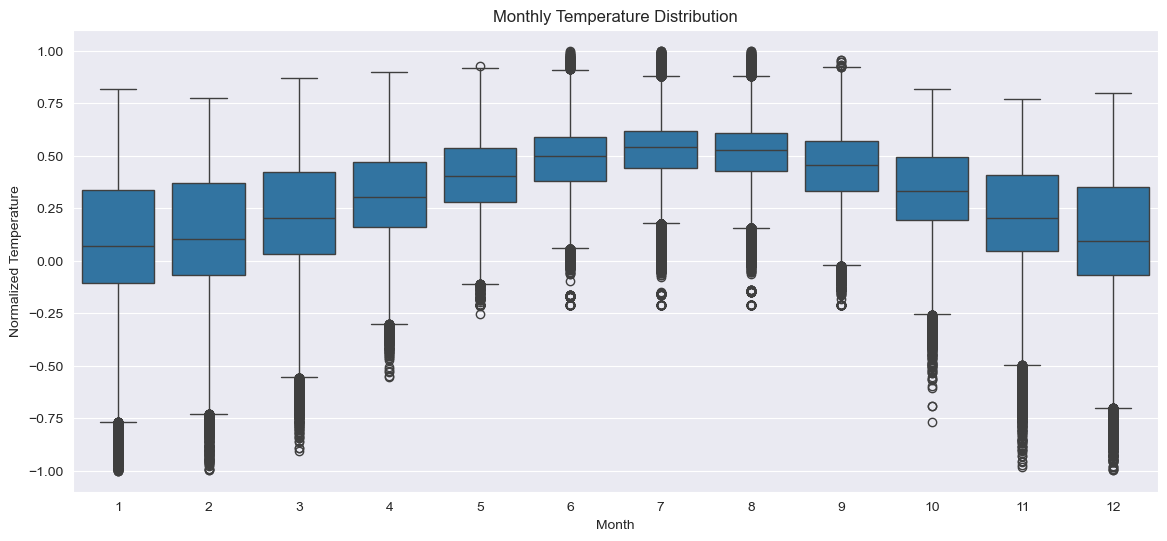

/var/folders/6l/_kjv1kfd461bglbcp2k8jyqh0000gn/T/ipykernel_36106/2771155410.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/uzair/.pyenv/versions/miniconda3-latest/envs/ProjectA/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


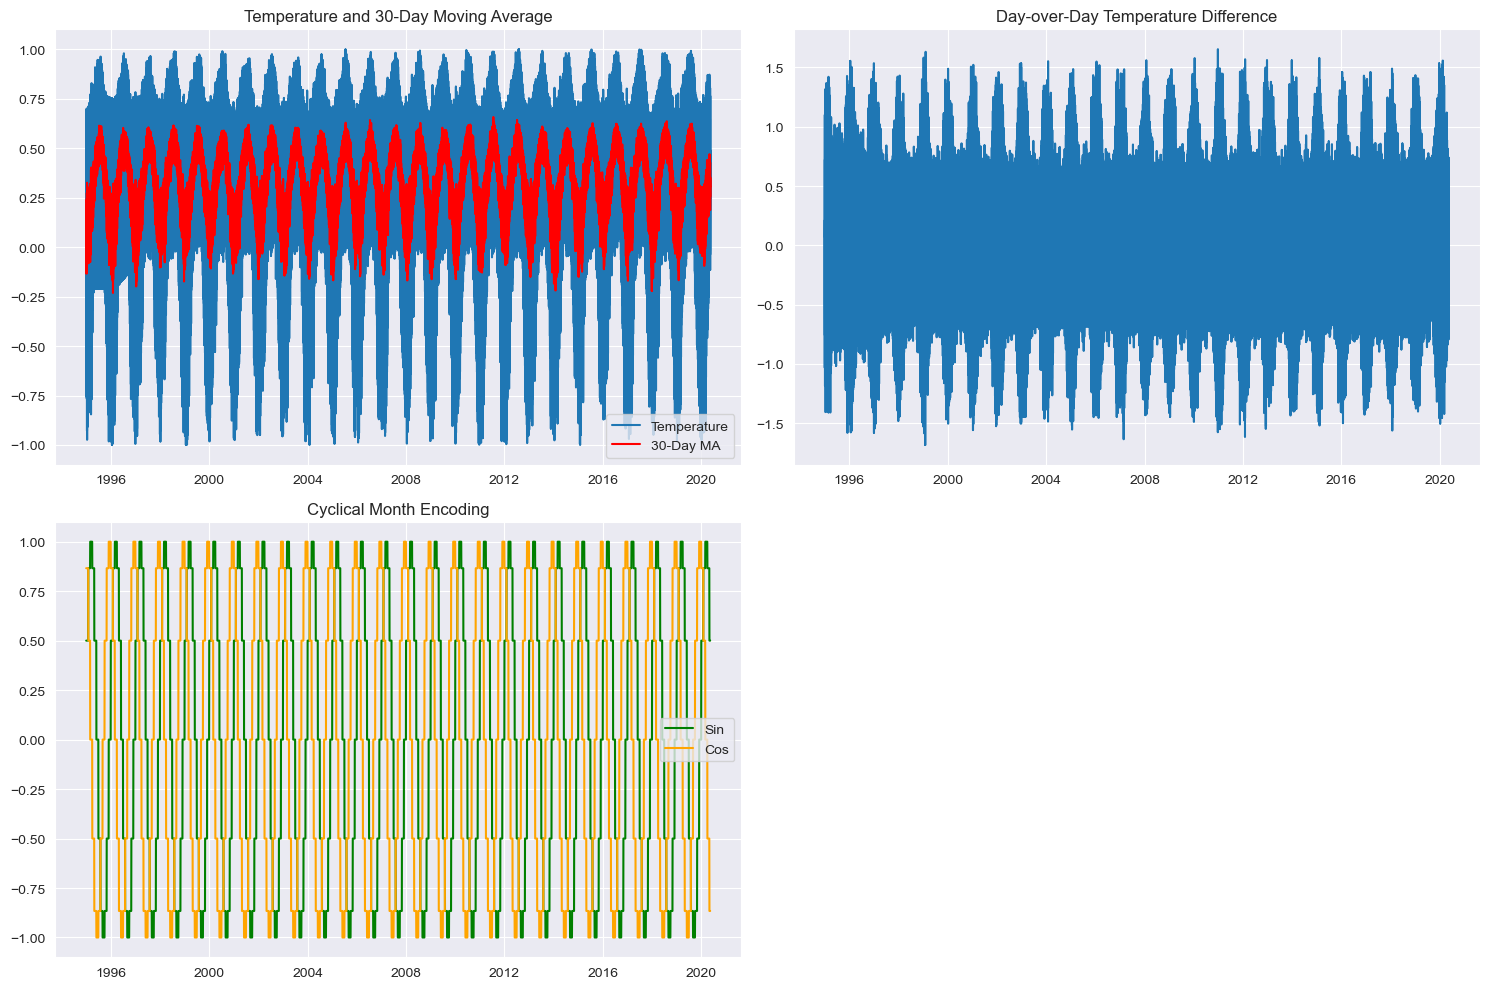

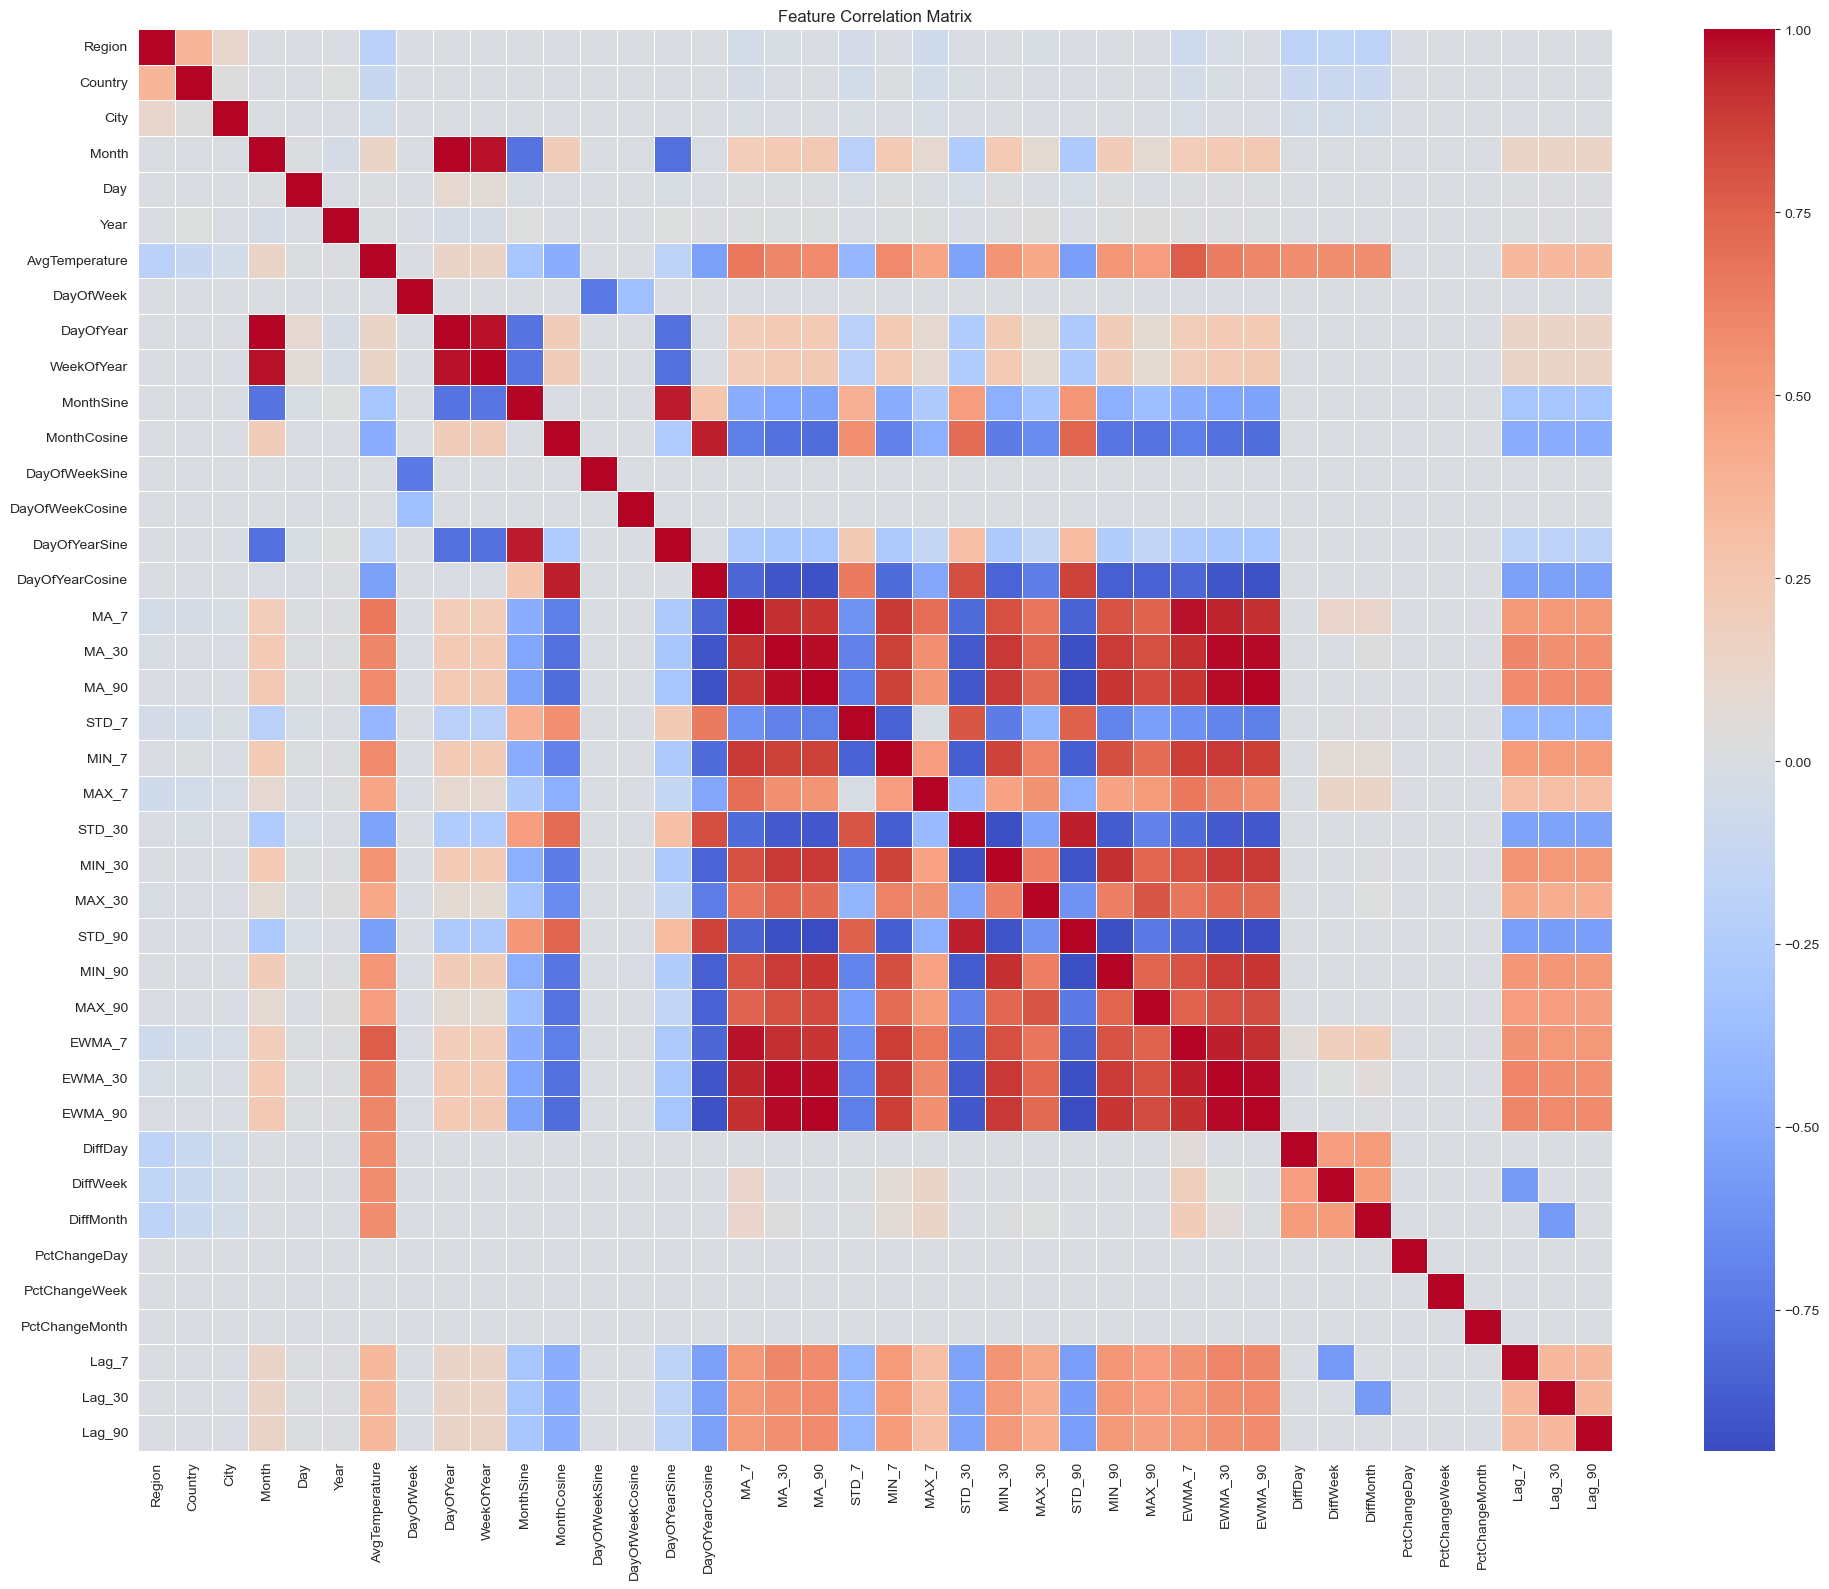

In [28]:
# Visualize the relationship between month and temperature
plt.figure(figsize=(14, 6))
sns.boxplot(x='Month', y='AvgTemperature', data=df_features.reset_index())
plt.title('Monthly Temperature Distribution')
plt.xlabel('Month')
plt.ylabel('Normalized Temperature')
plt.show()

# Visualize some of the created features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df_features.index, df_features['AvgTemperature'])
plt.plot(df_features.index, df_features['MA_30'], color='red')
plt.title('Temperature and 30-Day Moving Average')
plt.legend(['Temperature', '30-Day MA'])

plt.subplot(2, 2, 2)
plt.plot(df_features.index, df_features['DiffDay'])
plt.title('Day-over-Day Temperature Difference')

plt.subplot(2, 2, 3)
plt.plot(df_features.index, df_features['MonthSine'], color='green')
plt.plot(df_features.index, df_features['MonthCosine'], color='orange')
plt.title('Cyclical Month Encoding')
plt.legend(['Sin', 'Cos'])

plt.tight_layout()
plt.show()

# Correlation analysis of features
correlation_matrix = df_features.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


Feature Correlations with Average Temperature:


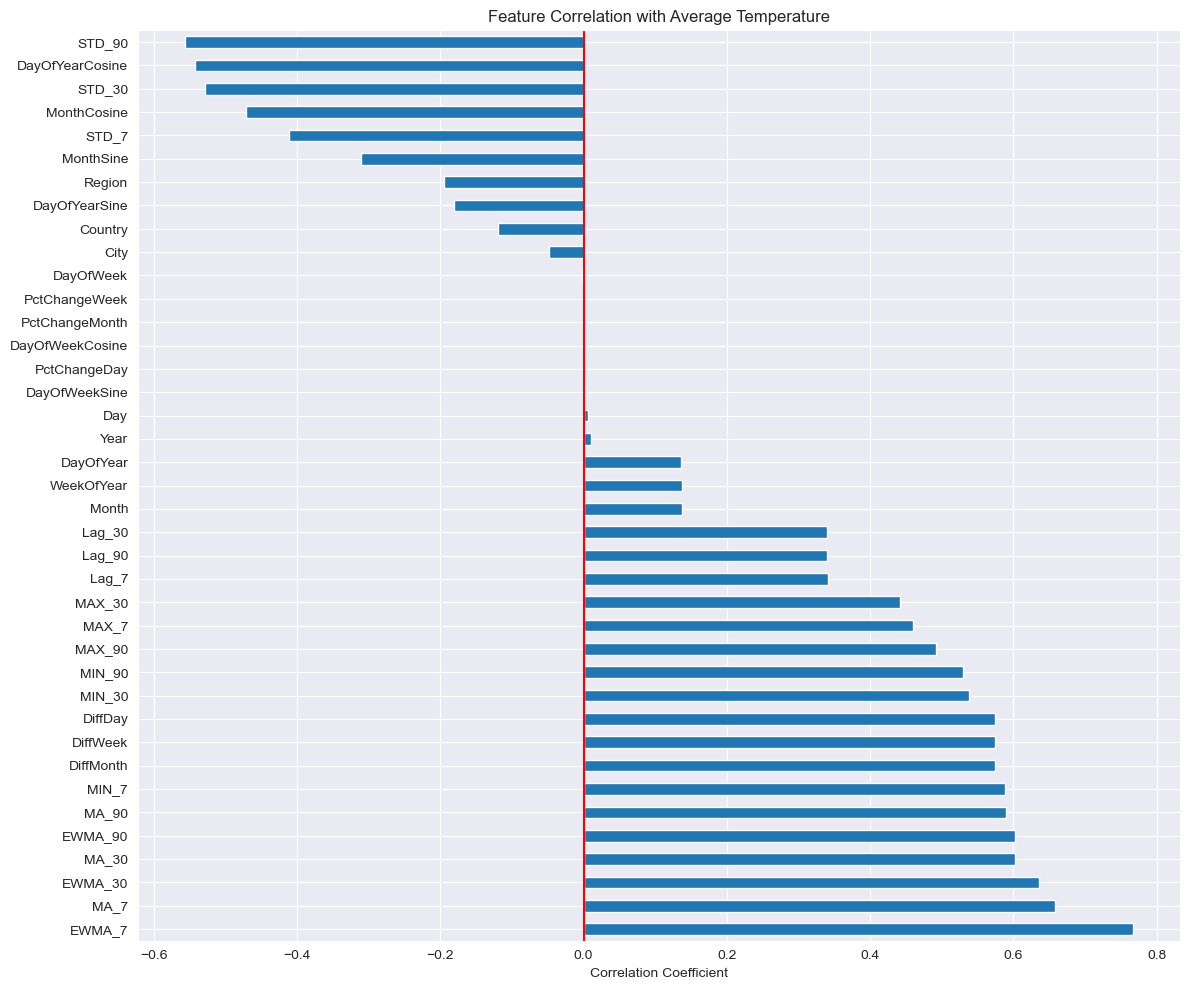

In [29]:
# Calculate correlation with the target variable
correlation_with_target = df_features.corr()['AvgTemperature'].sort_values(ascending=False)

# Display correlations
print("Feature Correlations with Average Temperature:")
# Visualize as a horizontal bar chart
plt.figure(figsize=(12, 10))
correlation_with_target.drop('AvgTemperature').plot(kind='barh')
plt.title('Feature Correlation with Average Temperature')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='r', linestyle='-')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Selection

We will now select the most relevant features for the model based on the correlation analysis.

In [30]:
def select_features(df_corr_with_target, corr_threshold=0.2):
    selected_features = df_corr_with_target[df_corr_with_target.abs() > corr_threshold].index.tolist()
    selected_features.remove('AvgTemperature')
    return selected_features

# Select features based on correlation
selected_features = select_features(correlation_with_target, corr_threshold=0.2)

selected_features

['EWMA_7',
 'MA_7',
 'EWMA_30',
 'MA_30',
 'EWMA_90',
 'MA_90',
 'MIN_7',
 'DiffMonth',
 'DiffWeek',
 'DiffDay',
 'MIN_30',
 'MIN_90',
 'MAX_90',
 'MAX_7',
 'MAX_30',
 'Lag_7',
 'Lag_90',
 'Lag_30',
 'MonthSine',
 'STD_7',
 'MonthCosine',
 'STD_30',
 'DayOfYearCosine',
 'STD_90']

# Model Training

## Data Preparation

In [31]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = df_features[selected_features]
y = df_features['AvgTemperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Linear Regression Model

In [32]:
def build_linear_regression_model(X_train, y_train, X_test):
    from sklearn.linear_model import LinearRegression

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return model, y_train_pred, y_test_pred

linear_model, y_train_pred, y_test_pred = build_linear_regression_model(X_train, y_train, X_test)

Linear Regression Model Evaluation:
Training RMSE: 0.0008
Testing RMSE: 0.0001
Training MAE: 0.0001
Testing MAE: 0.0001
Training R²: 1.0000
Testing R²: 1.0000


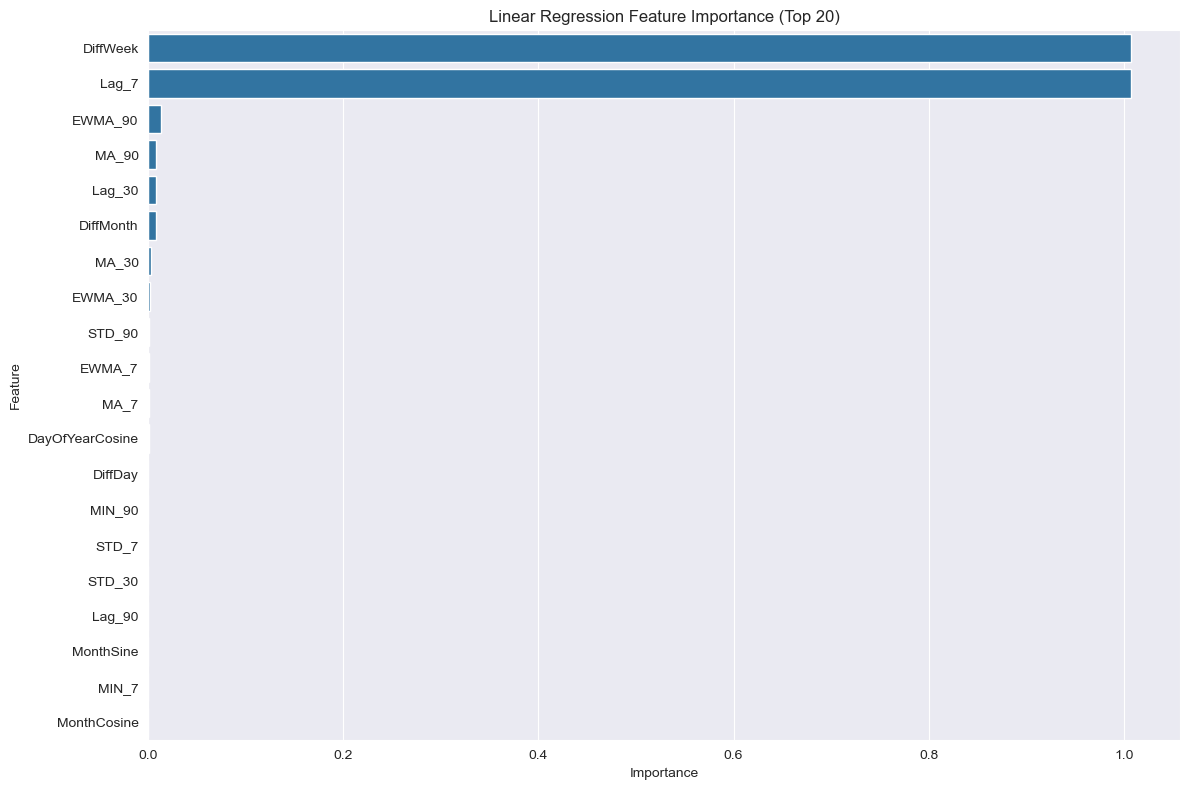

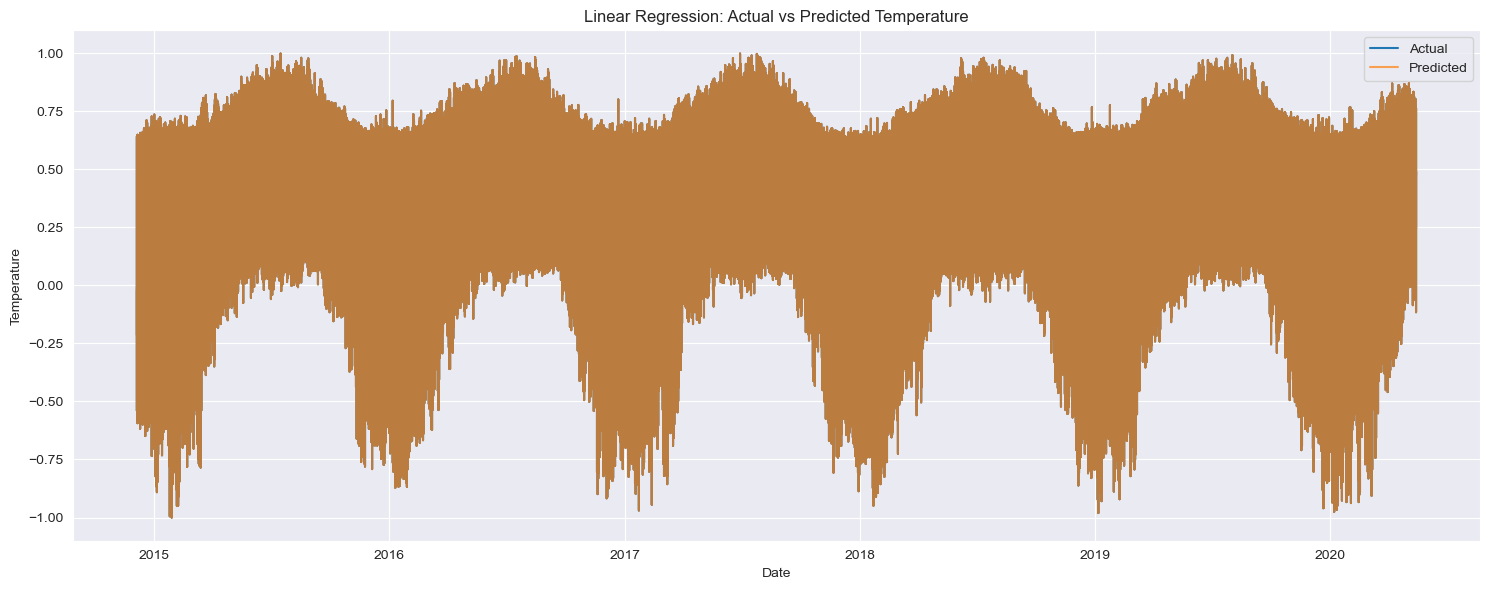

In [33]:
def evaluate_linear_regression_model(model, y_train_pred, y_test_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print evaluation metrics
    print("Linear Regression Model Evaluation:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

    # Feature importance (coefficients)
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(model.coef_)
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Linear Regression Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted', alpha=0.7)
    plt.title('Linear Regression: Actual vs Predicted Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_linear_regression_model(linear_model, y_train_pred, y_test_pred)

# Random Forest Model

In [35]:
def build_random_forest_model(X_train, y_train, X_test):
    from sklearn.ensemble import RandomForestRegressor

    # Initialize and train the model
    model = RandomForestRegressor(
        n_estimators=20,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return model, y_train_pred, y_test_pred

rf_model, rf_y_train_pred, rf_y_test_pred = build_random_forest_model(X_train, y_train, X_test)

Random Forest Model Evaluation:
Training RMSE: 0.0129
Testing RMSE: 0.0196
Training MAE: 0.0070
Testing MAE: 0.0107
Training R²: 0.9976
Testing R²: 0.9944


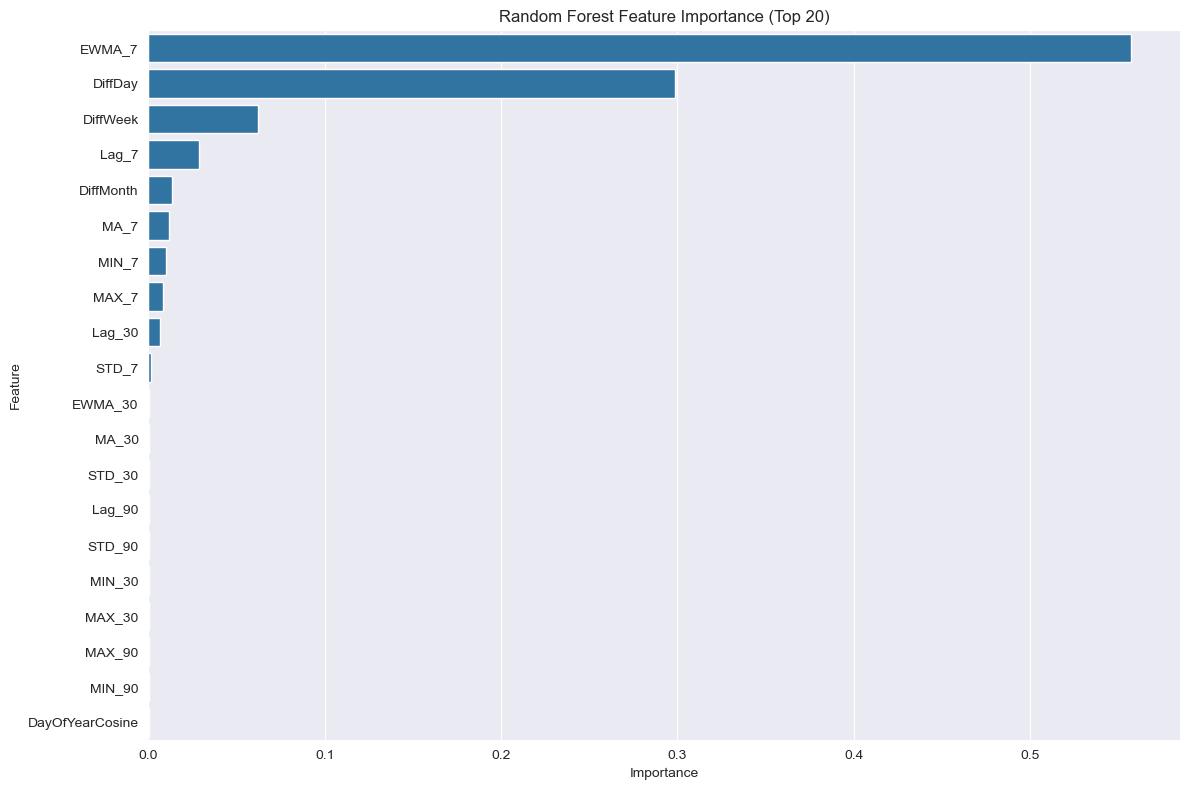

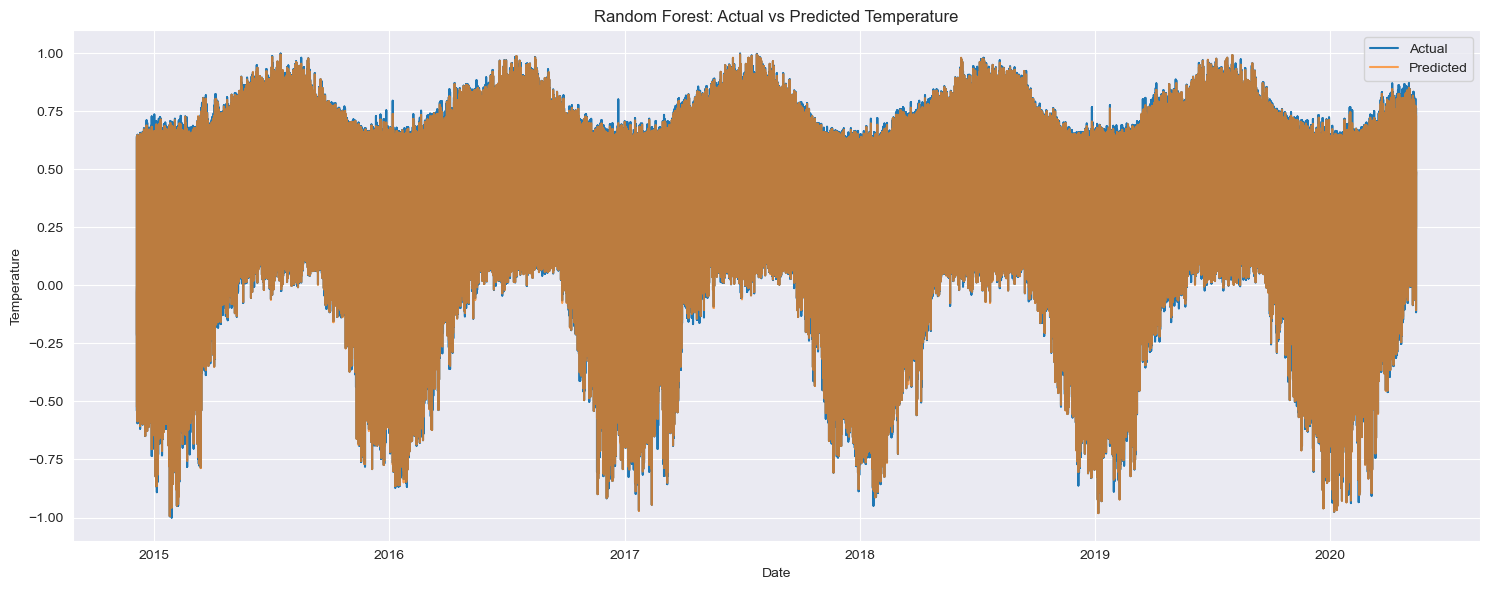

In [36]:
def evaluate_random_forest_model(model, y_train_pred, y_test_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print evaluation metrics
    print("Random Forest Model Evaluation:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Random Forest Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted', alpha=0.7)
    plt.title('Random Forest: Actual vs Predicted Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_random_forest_model(rf_model, rf_y_train_pred, rf_y_test_pred)

## XGBoost Model

In [37]:
def build_xgboost_model(X_train, y_train, X_test, y_test):
    import xgboost as xgb

    # Initialize and train the model
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        # eval_metric='rmse',
        # early_stopping_rounds=10,
        verbose=False
    )

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return model, y_train_pred, y_test_pred

xgb_model, xgb_y_train_pred, xgb_y_test_pred = build_xgboost_model(X_train, y_train, X_test, y_test)

XGBoost Model Evaluation:
Training RMSE: 0.0201
Testing RMSE: 0.0201
Training MAE: 0.0150
Testing MAE: 0.0150
Training R²: 0.9942
Testing R²: 0.9942


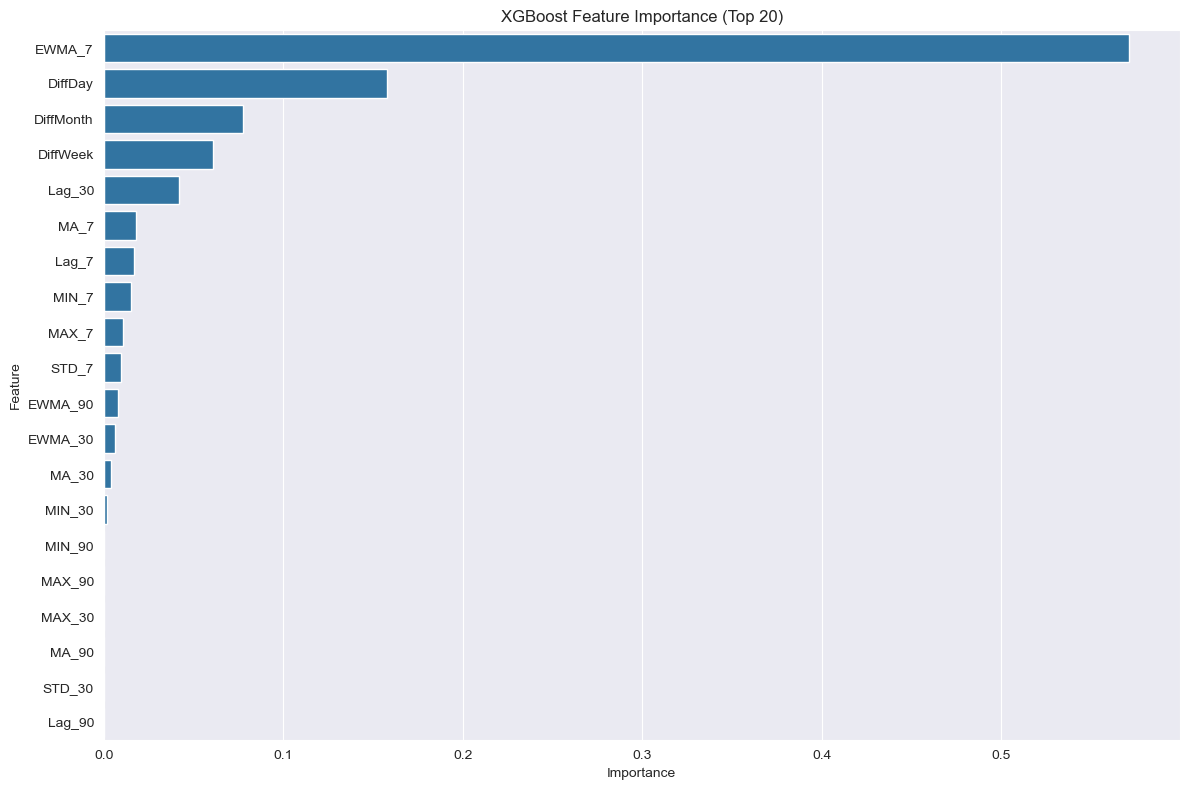

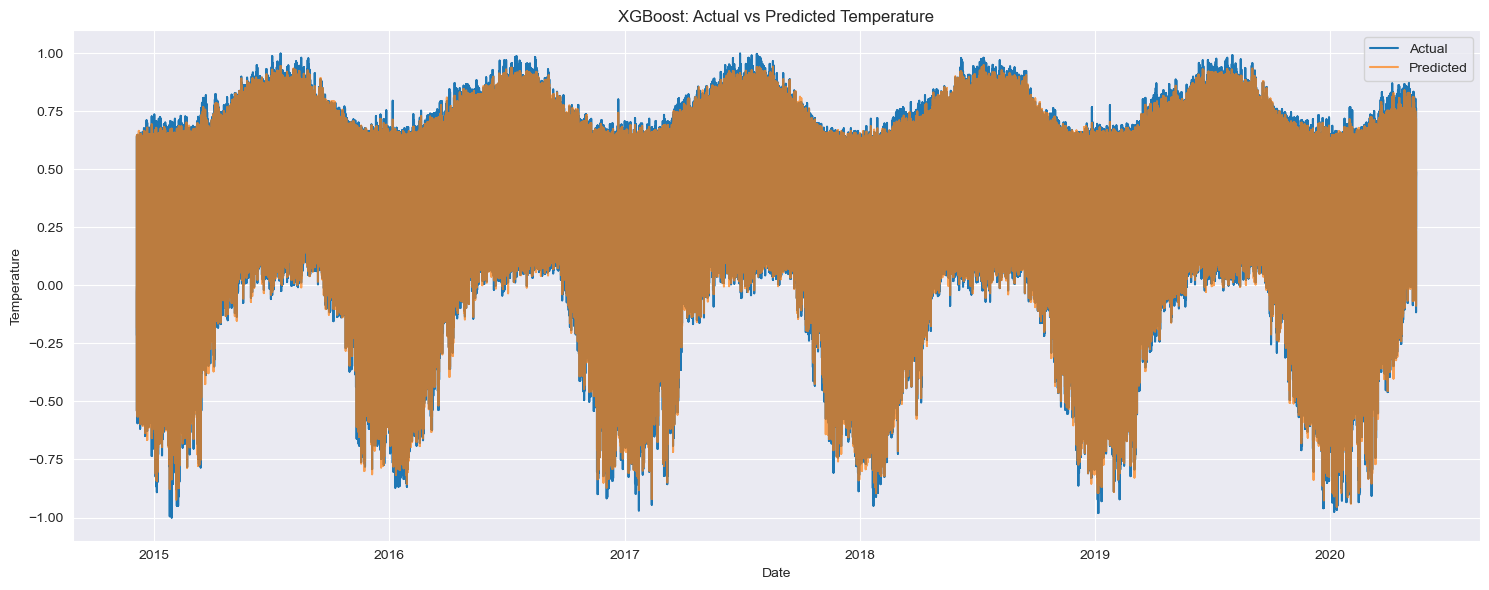

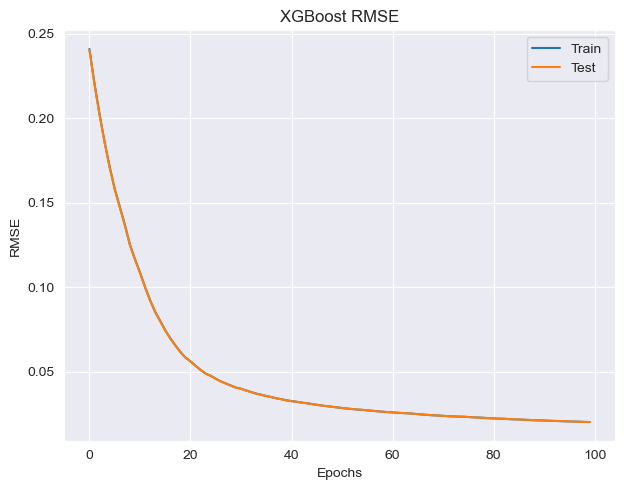

In [38]:
def evaluate_xgboost_model(model, y_train_pred, y_test_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print evaluation metrics
    print("XGBoost Model Evaluation:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('XGBoost Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted', alpha=0.7)
    plt.title('XGBoost: Actual vs Predicted Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot learning curves
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
    plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')

    plt.tight_layout()
    plt.show()

evaluate_xgboost_model(xgb_model, xgb_y_train_pred, xgb_y_test_pred)

## Time-Based Cross-Validation

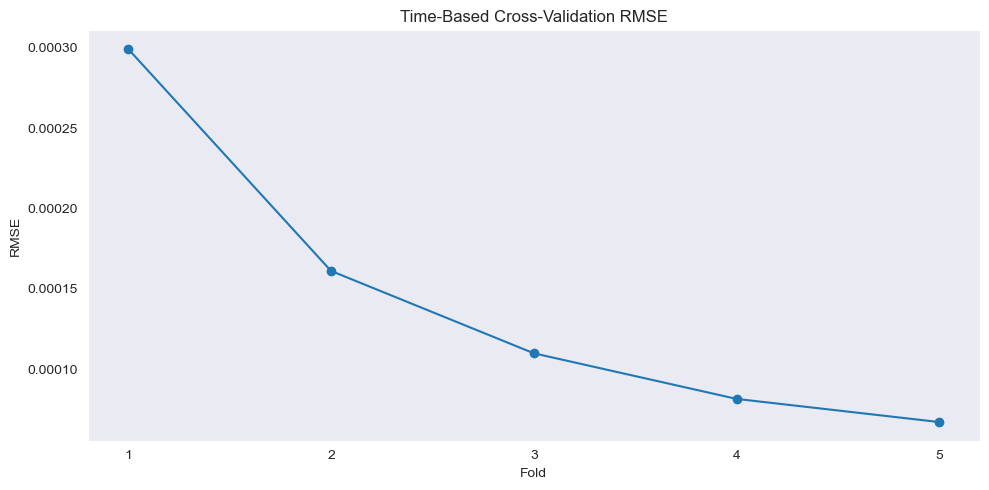

In [39]:
def time_based_cross_validation(X, y, model, n_splits=5):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append(rmse)

    return results

# Linear Regression model performed the best, so we will use it for time-based cross-validation
cv_results = time_based_cross_validation(X, y, linear_model)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cv_results) + 1), cv_results, marker='o')
plt.title('Time-Based Cross-Validation RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(range(1, len(cv_results) + 1))
plt.grid()
plt.tight_layout()
plt.show()

## Model Comparison

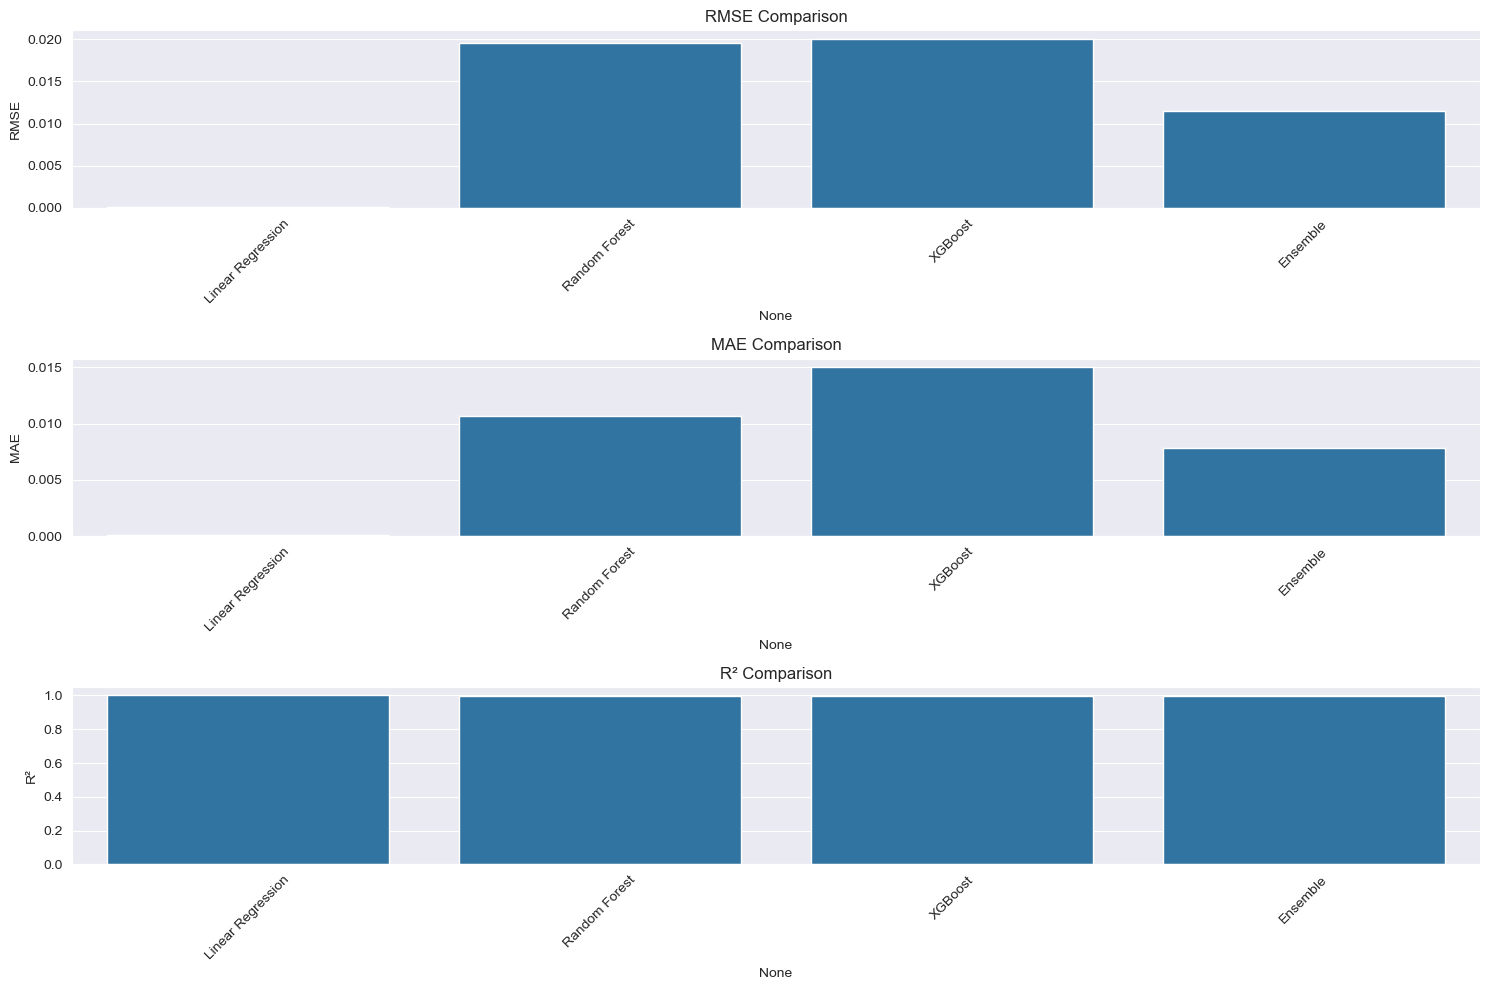

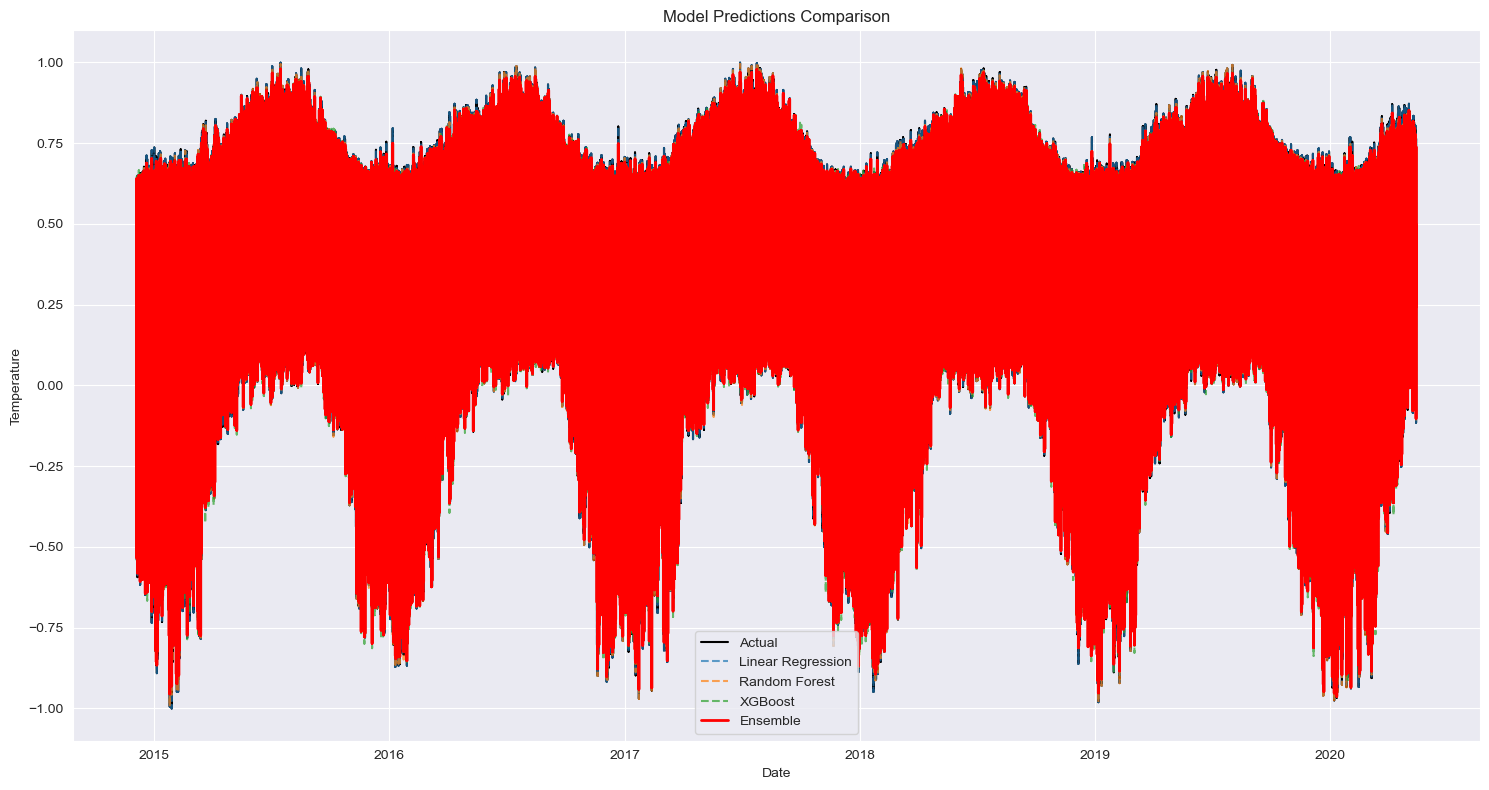

Model Comparison Metrics:


,RMSE,MAE,R²
Linear Regression,0.000069,0.000053,1.000000
Random Forest,0.019603,0.010677,0.994450
XGBoost,0.020072,0.015033,0.994181
Ensemble,0.011445,0.007832,0.998108


In [40]:
def compare_models(models_dict, y_test):
    """
    Compare multiple models and create an ensemble

    Parameters:
    -----------
    models_dict : dict
        Dictionary of model name: (model, predictions) pairs
    X_test : DataFrame
        Test features
    y_test : Series
        Test target values

    Returns:
    --------
    Ensemble predictions and metrics
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Collect all predictions
    all_preds = {}
    for name, (model, preds) in models_dict.items():
        all_preds[name] = preds

    # Create a DataFrame of predictions
    preds_df = pd.DataFrame(all_preds)

    # Create ensemble prediction (simple average)
    preds_df['Ensemble'] = preds_df.mean(axis=1)

    # Calculate metrics for all models including ensemble
    metrics = {}
    for column in preds_df.columns:
        pred = preds_df[column]
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        metrics[column] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

    # Convert metrics to DataFrame for easy viewing
    metrics_df = pd.DataFrame(metrics).T

    # Plot metrics comparison
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    sns.barplot(x=metrics_df.index, y='RMSE', data=metrics_df)
    plt.title('RMSE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 2)
    sns.barplot(x=metrics_df.index, y='MAE', data=metrics_df)
    plt.title('MAE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 3)
    sns.barplot(x=metrics_df.index, y='R²', data=metrics_df)
    plt.title('R² Comparison')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Plot predictions from all models
    plt.figure(figsize=(15, 8))
    plt.plot(y_test.index, y_test.values, 'k-', label='Actual')

    for column in preds_df.columns:
        if column == 'Ensemble':
            plt.plot(y_test.index, preds_df[column], 'r-', linewidth=2, label=column)
        else:
            plt.plot(y_test.index, preds_df[column], '--', alpha=0.7, label=column)

    plt.title('Model Predictions Comparison')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return preds_df, metrics_df

# Create a dictionary of models and their predictions
models_dict = {
    'Linear Regression': (linear_model, y_test_pred),
    'Random Forest': (rf_model, rf_y_test_pred),
    'XGBoost': (xgb_model, xgb_y_test_pred)
}

# Compare models and create ensemble
ensemble_preds, metrics_df = compare_models(models_dict, y_test)\

# Print metrics
print("Model Comparison Metrics:")
metrics_df